In [1]:
import cryoenv.cryosig as cs
import numpy as np
import time
from scipy.constants import e
from tqdm.auto import trange
import matplotlib.pyplot as plt

from scipy.optimize import brentq, minimize
from bayes_opt import BayesianOptimization
from iminuit import cost, Minuit

%config InlineBackend.figure_formats = ['svg']

In [2]:
# def funwrapper(p, verb=False):
# def funwrapper(G_eb, G_ab, G_ea, epsilon, delta, pulser_scale, verb=False):
def funwrapper(G_eb, G_ab, G_ea, epsilon, k, verb=False):
    
    # p = np.array(p)
    # G_eb, G_ab, G_ea, epsilon, delta, pulser_scale = p
    # if np.any(p < 0) or epsilon > 1. or delta > 1. or pulser_scale > 1.:
    #     return 1e5
#     G_eb, G_ab, G_ea, epsilon, k = p
#     if np.any(p < 0) or epsilon > 1.:
#         return 1e5
    
    # the fit pars
    pars = {
        'G': np.array([[0., G_ea], [G_ea, 0.], ]),
        'Gb': np.array([G_eb, G_ab]),
        'eps': np.array([[0.99, 0.01], [epsilon, 1 - epsilon], ]),
        # 'delta': np.array([[0., 1.], ]),
        # 'pulser_scale': np.array([.09]),
        'verb': verb,
        'k': np.array([k]),
           }
    
    # the known pars
    R_op = 0.085  # Ohm
    dac_xa = 0.
    dac_xb = 10.
    
    det = cs.DetectorModel(**pars)
    
    # bring control in OP
    
    try:
        def froot(dac):
            det.set_control(dac=[dac], Ib=[5.], norm=False)
            det.wait(5)
            rt = det.Rt[0](det.T[-1,0])
            return rt - R_op

        res = brentq(froot, dac_xa, dac_xb, rtol=1e-4)

        if verb:
            print(res, det.T[-1], det.Rt[0](det.T[-1,0]))
            
        loss = 0

        ## observable 1: pulse shape particle

        det.wait(5)

        det.trigger(er=np.array([0., (5.9 * 8/9 + 1/9 * 6.4)]), tpa=np.array([0.0]))

        evsim = det.get_record(no_noise=True)
        evmeas = np.interp(sev_p[:,0], sev_p[:,0] + 0.0026, sev_p[:,1]*0.37)

        if verb:        
            plt.plot(sev_p[:,0], evsim, label='sim')
            plt.plot(sev_p[:,0], evmeas, label='meas')
            plt.xlim(-0.005,0.03)
            plt.xlabel('Amplitude (V)')
            plt.xlabel('Time (s)')
            plt.legend()
            plt.title('sev particle')
            plt.show()

        loss += np.mean((evsim[4000:5000] - evmeas[4000:5000])**2)

        ## observable 2: pulse shape test pulse

#         det.wait(5)

#         det.trigger(er=np.array([0., 0.]), tpa=np.array([1.0]))

#         evsim = det.get_record(no_noise=True)
#         evmeas = np.interp(sev_tp[:,0], sev_tp[:,0], sev_tp[:,1]*0.37)

#         if verb:
#             plt.plot(sev_tp[:,0], evsim, label='sim')
#             plt.plot(sev_tp[:,0], evmeas, label='meas')
#             plt.xlim(-0.005,0.1)
#             plt.xlabel('Amplitude (V)')
#             plt.xlabel('Time (s)')
#             plt.legend()
#             plt.title('sev tp')
#             plt.show()

#         loss += np.mean((evsim[4000:6000] - evmeas[4000:6000])**2)

        # print('loss: {:.2e} | G_eb: {:.2e} | G_ab: {:.2e} | G_ea: {:.2e} | eps: {:.2e} | del: {:.2e} | p_sc: {:.2e}'.format(loss, *p))
        # print("loss: {:.2e} | dac: {:.2e} | 'G_eb': {:.2e}, 'G_ab': {:.2e}, 'G_ea': {:.2e}, 'eps': {:.2e}, 'k': {:.2e}".format(loss, res, *p))

        # obaservable 3: noise power spectrum

        # loss += 

    except ValueError:
        loss = 1e5
    
    # return loss
    return -loss

In [4]:
pbounds = {'G_eb': (1e-6, 5.), 
           'G_ab': (1e-6, 5.), 
           'G_ea': (1e-6, 5.), 
           'epsilon': (.01, .5), 
           # 'delta': (0., 1.), 
           # 'pulser_scale': (0., 1.),
           'k': (1, 10), 
          }

In [12]:
optimizer = BayesianOptimization(
    f=funwrapper,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
    allow_duplicate_points=True,
)


In [13]:
optimizer.set_bounds(new_bounds=pbounds)

In [14]:
optimizer.probe(
    params={'G_eb': 1.2e-1, 
           'G_ab': 1.5e0, 
           'G_ea': 2e-1, 
           'epsilon': 0.1, 
           # 'delta': 0., 
           # 'pulser_scale': 0.09,
            'k': 3.5,
          },
    lazy=True,
)


In [15]:
optimizer.maximize(
    init_points=20,
    n_iter=50,
)

|   iter    |  target   |   G_ab    |   G_ea    |   G_eb    |  epsilon  |     k     |
-------------------------------------------------------------------------------------
| 1         | -0.01991  | 1.5       | 0.2       | 0.12      | 0.1       | 3.5       |
| 2         | -0.02025  | 2.085     | 3.602     | 0.0005729 | 0.1581    | 2.321     |
| 3         | -0.02314  | 0.4617    | 0.9313    | 1.728     | 0.2044    | 5.849     |
| 4         | -0.02278  | 2.096     | 3.426     | 1.022     | 0.4403    | 1.246     |
| 5         | -0.02279  | 3.352     | 2.087     | 2.793     | 0.07879   | 2.783     |
| 6         | -0.02321  | 4.004     | 4.841     | 1.567     | 0.3492    | 8.888     |
| 7         | -102.5    | 4.473     | 0.4252    | 0.1953    | 0.09322   | 8.903     |
| 8         | -0.02266  | 0.4917    | 2.106     | 4.789     | 0.2713    | 7.227     |
| 9         | -0.01939  | 1.578     | 3.433     | 4.173     | 0.01896   | 7.751     |
| 10        | -0.02285  | 4.944     | 3.741     | 1.40

/Users/felix/.pyenv/versions/3.10.10/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


| 23        | -1e+05    | 3.887     | 4.906     | 1e-06     | 0.5       | 5.604     |


/Users/felix/.pyenv/versions/3.10.10/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


| 24        | -1e+05    | 1.706     | 2.775     | 1.88      | 0.5       | 10.0      |
| 25        | -0.02463  | 0.7496    | 2.504     | 3.437     | 0.5       | 4.366     |
| 26        | -0.02314  | 1.927     | 4.354     | 4.374     | 0.5       | 2.416     |
| 27        | -1e+05    | 5.0       | 2.478     | 3.932     | 0.5       | 1.0       |
| 28        | -0.02129  | 1.502     | 2.32      | 1.608     | 0.01      | 3.362     |
| 29        | -0.02093  | 2.636     | 4.043     | 3.02      | 0.08149   | 4.137     |
| 30        | -0.02214  | 1e-06     | 4.252     | 2.517     | 0.01      | 2.098     |
| 31        | -0.02143  | 3.694     | 1.383     | 1e-06     | 0.01      | 2.196     |
| 32        | -0.02241  | 1e-06     | 1.514     | 0.4175    | 0.01      | 1.29      |
| 33        | -0.02318  | 1e-06     | 4.378     | 5.0       | 0.5       | 5.784     |
| 34        | -1e+05    | 1e-06     | 1e-06     | 2.54      | 0.01      | 3.007     |
| 35        | -0.02124  | 0.1137    | 2.652     | 2.83

/Users/felix/.pyenv/versions/3.10.10/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


| 36        | -1e+05    | 2.127     | 1.2       | 0.1495    | 0.2862    | 5.764     |
| 37        | -0.02257  | 1.666     | 3.277     | 2.9       | 0.01      | 2.467     |
| 38        | -0.02139  | 0.3176    | 4.288     | 4.158     | 0.01      | 3.774     |
| 39        | -0.02154  | 0.04104   | 3.417     | 0.5966    | 0.5       | 2.548     |
| 40        | -0.02389  | 1.795     | 1.364     | 1e-06     | 0.5       | 1.775     |
| 41        | -0.02375  | 1e-06     | 3.794     | 4.757     | 0.5       | 1.0       |


/Users/felix/.pyenv/versions/3.10.10/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


| 42        | -1e+05    | 1e-06     | 4.889     | 5.0       | 0.01      | 8.087     |
| 43        | -0.02124  | 1.235     | 3.041     | 4.632     | 0.1471    | 5.452     |
| 44        | -1e+05    | 3.887     | 1e-06     | 1.317     | 0.5       | 2.84      |
| 45        | -0.022    | 3.29      | 3.059     | 1.271     | 0.01      | 2.652     |
| 46        | -0.02288  | 3.815     | 2.937     | 1e-06     | 0.01      | 1.187     |
| 47        | -0.02313  | 0.07384   | 2.9       | 1.634     | 0.1703    | 1.028     |
| 48        | -0.02188  | 1.968     | 4.984     | 4.742     | 0.3245    | 4.656     |
| 49        | -0.02276  | 2.351     | 2.764     | 4.641     | 0.01      | 3.463     |
| 50        | -0.02261  | 1e-06     | 0.4683    | 3.234     | 0.01      | 7.056     |
| 51        | -0.02265  | 3.864     | 4.951     | 3.712     | 0.1026    | 2.749     |
| 52        | -0.02259  | 0.3975    | 5.0       | 0.201     | 0.01      | 1.0       |
| 53        | -0.0235   | 1.217     | 4.848     | 3.04

/Users/felix/.pyenv/versions/3.10.10/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


| 57        | -1e+05    | 1e-06     | 5.0       | 1e-06     | 0.01      | 3.676     |


/Users/felix/.pyenv/versions/3.10.10/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/felix/.pyenv/versions/3.10.10/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


| 58        | -1e+05    | 1.265     | 3.147     | 2.571     | 0.2774    | 5.533     |
| 59        | -1e+05    | 4.576     | 0.3263    | 0.2146    | 0.09923   | 8.881     |
| 60        | -0.02106  | 2.339     | 2.779     | 3.472     | 0.08018   | 5.366     |
| 61        | -1e+05    | 0.8118    | 0.2508    | 3.189     | 0.2567    | 8.288     |
| 62        | -0.02585  | 4.777     | 3.841     | 2.55      | 0.4082    | 7.918     |
| 63        | -1e+05    | 4.144     | 1.848     | 4.013     | 0.2295    | 4.566     |
| 64        | -0.02187  | 4.915     | 3.919     | 0.4871    | 0.2126    | 2.186     |
| 65        | -0.02584  | 0.2153    | 0.2794    | 3.509     | 0.2429    | 6.442     |
| 66        | -0.02305  | 2.368     | 3.141     | 2.941     | 0.1091    | 1.889     |


/Users/felix/.pyenv/versions/3.10.10/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


| 67        | -1e+05    | 1.093     | 1.435     | 0.04879   | 0.1698    | 4.578     |
| 68        | -0.03146  | 0.8779    | 0.8328    | 0.7581    | 0.3878    | 4.282     |
| 69        | -0.0227   | 4.816     | 3.774     | 2.03      | 0.1296    | 2.258     |
| 70        | -0.02239  | 3.019     | 3.172     | 4.342     | 0.2787    | 5.898     |
| 71        | -1e+05    | 4.631     | 0.9874    | 2.317     | 0.2659    | 3.351     |


In [16]:
print(optimizer.max)

{'target': -0.017430646295091386, 'params': {'G_ab': 0.0968357699845275, 'G_ea': 3.394177985863922, 'G_eb': 1.0581413683721792, 'epsilon': 0.14011786309239085, 'k': 5.424158433523044}}


In [16]:
def funwrapper(G_eb, G_ab, G_ea, epsilon, k, verb=False):

    # the fit pars
    pars = {
        'G': np.array([[0., G_ea], [G_ea, 0.], ]),
        'Gb': np.array([G_eb, G_ab]),
        'eps': np.array([[0.99, 0.01], [epsilon, 1 - epsilon], ]),
        'verb': verb,
        'k': np.array([k]),
           }
    
    # the known pars
    R_op = 0.085  # Ohm
    dac_xa = 0.
    dac_xb = 10.
    
    det = cs.DetectorModel(**pars)
    
    # bring control in OP
    try:
        def froot(dac):
            det.set_control(dac=[dac], Ib=[5.], norm=False)
            det.wait(5)
            rt = det.Rt[0](det.T[-1,0])
            return rt - R_op

        res = brentq(froot, dac_xa, dac_xb, rtol=1e-4)

        out = np.zeros(det.record_length)

    ## observable 1: pulse shape particle

        det.wait(5)

        det.trigger(er=np.array([0., (5.9 * 8/9 + 1/9 * 6.4)]), tpa=np.array([0.0]))

        evsim = det.get_record(no_noise=True)

    except ValueError:
        out = np.zeros(det.record_length)

    return out[4000:6000]

In [8]:
init_val = [1.2e-1, 1.5e0, 2e-1, 0.1, 3.5]  # , 0., 0.09

In [100]:
res = minimize(funwrapper, x0=init_val, method='Nelder-Mead', 
               options={'adaptive': True, 'maxiter': 200},
               args=(False))

loss: 1.99e-02 | dac: 1.70e+00 | 'G_eb': 1.20e-01, 'G_ab': 1.50e+00, 'G_ea': 2.00e-01, 'eps': 1.00e-01, 'k': 3.50e+00
loss: 1.99e-02 | dac: 1.74e+00 | 'G_eb': 1.26e-01, 'G_ab': 1.50e+00, 'G_ea': 2.00e-01, 'eps': 1.00e-01, 'k': 3.50e+00
loss: 1.99e-02 | dac: 1.79e+00 | 'G_eb': 1.20e-01, 'G_ab': 1.58e+00, 'G_ea': 2.00e-01, 'eps': 1.00e-01, 'k': 3.50e+00
loss: 1.99e-02 | dac: 1.68e+00 | 'G_eb': 1.20e-01, 'G_ab': 1.50e+00, 'G_ea': 2.10e-01, 'eps': 1.00e-01, 'k': 3.50e+00
loss: 2.01e-02 | dac: 1.70e+00 | 'G_eb': 1.20e-01, 'G_ab': 1.50e+00, 'G_ea': 2.00e-01, 'eps': 1.05e-01, 'k': 3.50e+00
loss: 2.00e-02 | dac: 1.70e+00 | 'G_eb': 1.20e-01, 'G_ab': 1.50e+00, 'G_ea': 2.00e-01, 'eps': 1.00e-01, 'k': 3.68e+00
loss: 1.98e-02 | dac: 1.74e+00 | 'G_eb': 1.22e-01, 'G_ab': 1.53e+00, 'G_ea': 2.04e-01, 'eps': 9.50e-02, 'k': 3.57e+00
loss: 1.97e-02 | dac: 1.75e+00 | 'G_eb': 1.23e-01, 'G_ab': 1.54e+00, 'G_ea': 2.05e-01, 'eps': 9.30e-02, 'k': 3.58e+00
loss: 1.98e-02 | dac: 1.76e+00 | 'G_eb': 1.24e-01, 'G_ab

/Users/felix/.pyenv/versions/3.10.10/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


loss: 1.50e-02 | dac: 1.14e+00 | 'G_eb': 1.74e-02, 'G_ab': 1.61e+00, 'G_ea': 3.90e-01, 'eps': 1.61e-02, 'k': 8.83e+00
loss: 1.49e-02 | dac: 1.14e+00 | 'G_eb': 1.26e-02, 'G_ab': 1.64e+00, 'G_ea': 3.94e-01, 'eps': 1.52e-02, 'k': 9.09e+00
loss: 1.50e-02 | dac: 1.14e+00 | 'G_eb': 1.42e-02, 'G_ab': 1.63e+00, 'G_ea': 3.99e-01, 'eps': 8.72e-03, 'k': 9.26e+00
loss: 1.53e-02 | dac: 1.12e+00 | 'G_eb': 3.16e-02, 'G_ab': 1.51e+00, 'G_ea': 3.80e-01, 'eps': 2.19e-02, 'k': 8.18e+00
loss: 8.39e+01 | dac: 1.10e+00 | 'G_eb': 2.06e-02, 'G_ab': 1.51e+00, 'G_ea': 3.85e-01, 'eps': 1.93e-02, 'k': 9.04e+00
loss: 1.53e-02 | dac: 1.16e+00 | 'G_eb': 2.25e-02, 'G_ab': 1.61e+00, 'G_ea': 3.90e-01, 'eps': 1.25e-02, 'k': 8.49e+00
loss: 2.47e-02 | dac: 1.19e+00 | 'G_eb': 1.51e-02, 'G_ab': 1.67e+00, 'G_ea': 3.77e-01, 'eps': 1.68e-02, 'k': 9.20e+00
loss: 1.52e-02 | dac: 1.11e+00 | 'G_eb': 2.47e-02, 'G_ab': 1.53e+00, 'G_ea': 3.93e-01, 'eps': 1.39e-02, 'k': 8.45e+00
loss: 1.51e-02 | dac: 1.15e+00 | 'G_eb': 7.44e-03, 'G_ab

In [101]:
res

       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: 0.014309152392809587
             x: [ 4.013e-06  1.669e+00  3.945e-01  1.505e-02  1.009e+01]
           nit: 200
          nfev: 432
 final_simplex: (array([[ 4.013e-06,  1.669e+00, ...,  1.505e-02,
                         1.009e+01],
                       [ 6.336e-06,  1.669e+00, ...,  1.506e-02,
                         1.009e+01],
                       ...,
                       [ 6.150e-06,  1.669e+00, ...,  1.505e-02,
                         1.009e+01],
                       [ 8.211e-06,  1.669e+00, ...,  1.506e-02,
                         1.009e+01]]), array([ 1.431e-02,  1.431e-02,  1.431e-02,  1.431e-02,
                        1.431e-02,  1.000e+05]))

ADC range exceeded!
ADC range exceeded!
ADC range exceeded!
1.7037087379193896 [31.31011376 40.00795452] 0.08495063271899152
T0 is [31.31010957 40.00794627] mK.
Calculated in 0.6140100955963135 s.
Generated noise in 0.008348941802978516 s.


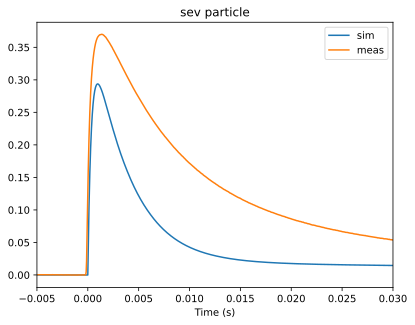

CPU times: user 3.01 s, sys: 159 ms, total: 3.17 s
Wall time: 2.88 s


In [5]:
%time loss = funwrapper(*[1.2e-1, 1.5e0, 2e-1, 0.1, 3.5], verb=True)
# %time loss = funwrapper(**optimizer.max['params'], verb=True)

In [2]:
det = cs.DetectorModel()

In [8]:
det.set_control(dac=[1.662], Ib=[5], norm=False)

det.wait(5)

det.trigger(er=np.array([0., 6.]), tpa=np.array([.0]))

T0 is [31.26813539 39.37214759] mK.
Calculated in 0.6325459480285645 s.
Generated noise in 0.006341695785522461 s.


array([0.382033])

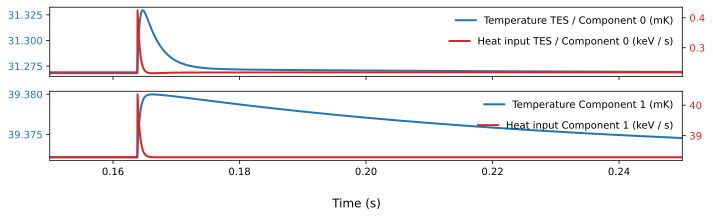

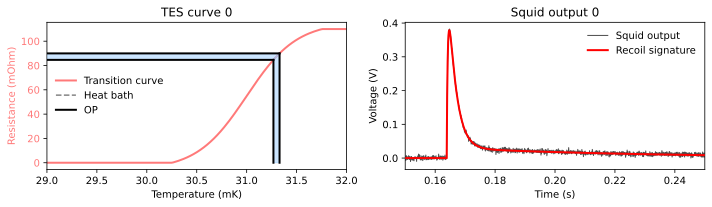

In [9]:
det.plot_temperatures(save_path=None, xlim=(0.15, 0.25))  # 'plots_paper/temperatures.png'
det.plot_tes(xlim_temp=(29., 32.), xlim_time=(0.15, 0.25), save_path=None)  # 'plots_paper/tes.png'

In [9]:
det.print_noise_parameters()

Resistance TES / Resistance normal conducting: 0.7695949783115494
Temperature mixing chamber: 15.0 mK
Temperature TES: 31.268135387942895 mK
Resistance TES: 84.65544761427043 mOhm
Tau eff: 8.7034454781757 ms
TES Slope: 91.83915033938263 mOhm/mK
C: 1781.5021025594094 fJ / K 
Geff: 204.6892931111719 pW / K
Tau in: 14.845850854661746 ms
Geb: 120.0 pW / K 
G ETF: 84.6892931111719 pW / K 
R shunt: 40.0 mOhm
Temperature shunt: 15.0 mK
i sq: 1.2 pA/sqrt(Hz)
1 / f amplitude (pW): 0.00012 
1 / f power (flicker slope): 1.5 
Tau el (s): 2.807739306211695e-06 
Tau I (s): -0.01530372331244615 
L_I (): 1.9700809764763567 
